In [104]:
import numpy as np #Working with arrays
import pandas as pd #working with the dataset from yfinance API
import yfinance as yf
import matplotlib.pyplot as plt #need some visualisation

#Build and train the model with pytorch
import torch
import torch.nn as nn
import torch.optim as optim

#Scale and evaluate our metric
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [105]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [122]:
ticker = 'TSLA'
df = yf.download(ticker, '2020-01-01')

C:\Users\Steven\AppData\Local\Temp\ipykernel_28040\2748477947.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, '2020-01-01')
[*********************100%***********************]  1 of 1 completed


In [123]:
df

Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2020-01-02,28.684000,28.713333,28.114000,28.299999,142981500
2020-01-03,29.534000,30.266666,29.128000,29.366667,266677500
2020-01-06,30.102667,30.104000,29.333332,29.364668,151995000
2020-01-07,31.270666,31.441999,30.224001,30.760000,268231500
2020-01-08,32.809334,33.232666,31.215334,31.580000,467164500
...,...,...,...,...,...
2025-07-07,293.940002,296.149994,288.769989,291.369995,131177900
2025-07-08,297.809998,304.049988,294.350006,297.000000,103246700


<AxesSubplot:xlabel='Date'>

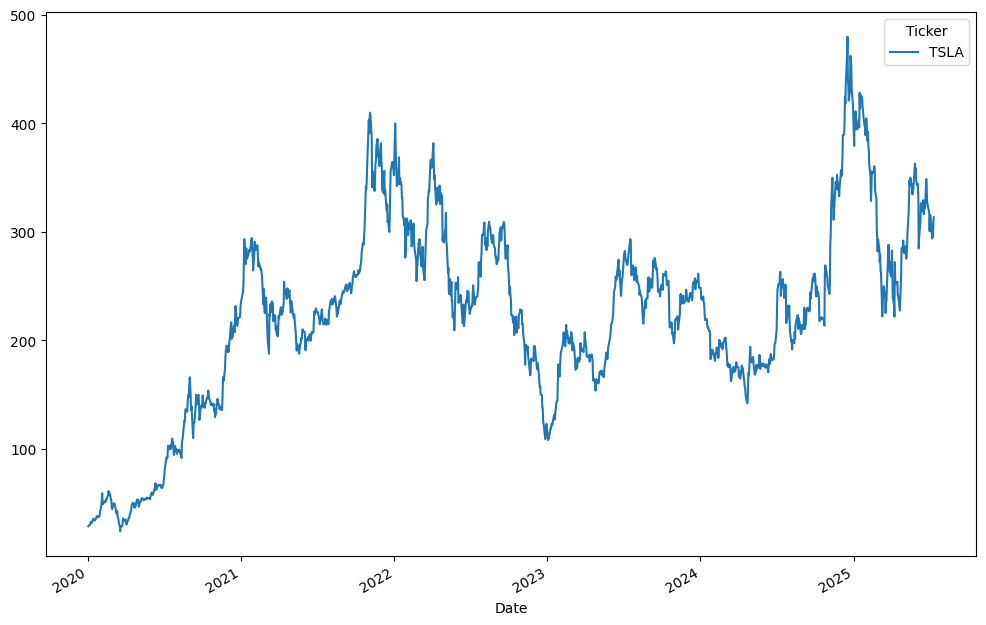

In [124]:
df.Close.plot(figsize=(12,8))

In [125]:
scaler = StandardScaler()

df['Close'] = scaler.fit_transform(df['Close'])

In [126]:
df.Close

Ticker,TSLA
Date,
2020-01-02,-2.246633
2020-01-03,-2.236809
2020-01-06,-2.230236
2020-01-07,-2.216737
2020-01-08,-2.198953
...,...
2025-07-07,0.819171
2025-07-08,0.863900
2025-07-09,0.841593


In [127]:
seq_length = 30 #using 30 days
data = []

#The first 29 days will be used to predict the price on the 30th day
#EG: SEQ_LENGTH = 3 --->      _ _ _ _ _ _ _ _  The first 2 _ will be used as inputs and third _ is the day we are trying to predict
for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)

train_size = int(0.8 * len(data)) #80% as the training data

X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)


In [128]:
class PredictionModel(nn.Module):

    def __init__ (self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        #Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.fc(out[:, -1, :])

        return out
    

In [129]:
 model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device) #mOdule needs to be sent to GPU

In [130]:
criterion = nn.MSELoss() #MEAN SQUARED ERROR
optimiser = optim.Adam(model.parameters(), lr=0.01) #learning rate = 0.01 for now

In [131]:
num_epochs = 200

'''
0 0.5805646181106567
25 0.008104835636913776
50 0.0013488366967067122
75 0.0011901888065040112
100 0.0011083872523158789
125 0.0010651190532371402
150 0.001029541832394898
175 0.0009981952607631683

the loss (right) decreases
'''

for i in range(num_epochs):

    #Make the prediction
    y_train_pred = model(X_train)

    #We see how wrong is this prediction
    loss = criterion(y_train_pred, y_train) # prediction vs actual values

    if i % 25 == 0:
        print(i,loss.item())

    #We back propogate the loss and tweak it to move in the correct direction
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

0 0.845991313457489
25 0.029851747676730156
50 0.014603651128709316
75 0.012656858190894127
100 0.011464403942227364
125 0.010549904778599739
150 0.00989572238177061
175 0.009563210420310497


In [132]:
#THAT WAS THE TRAINED MODEL, NOW LETS SEE THE HOW THE MODEL PERFORMS ON UNSEEN DATA

In [133]:
model.eval()

y_test_pred = model(X_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())


In [134]:
train_rmse = root_mean_squared_error(y_train[:,0], y_train_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:,0], y_test_pred[:, 0])

In [135]:
train_rmse

8.4021577835083

In [136]:
test_rmse

14.042448997497559

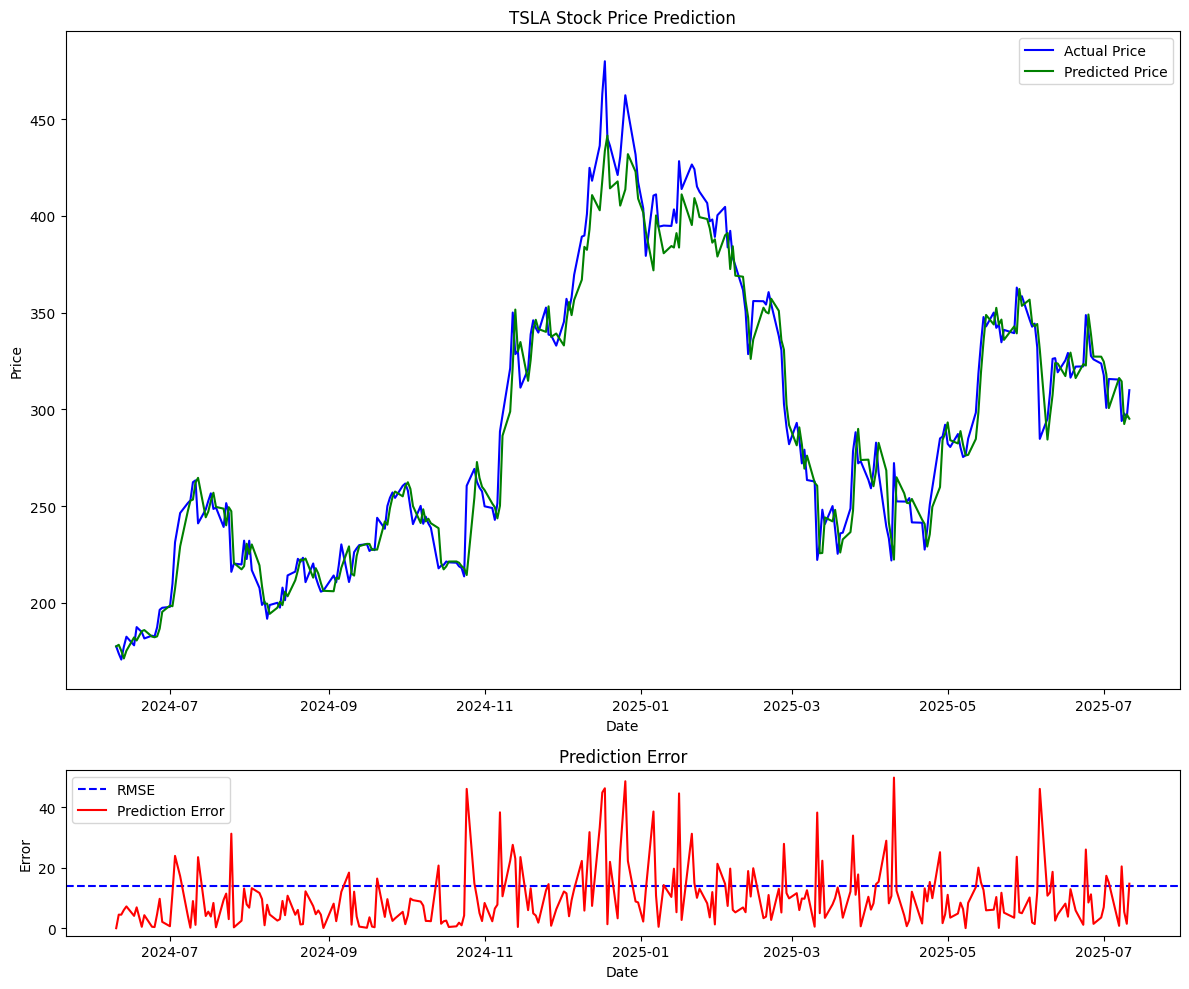

In [137]:
# Ensure predictions are numpy arrays
y_test_np = y_test.detach().cpu().numpy().squeeze() if hasattr(y_test, 'detach') else y_test.squeeze()
y_test_pred_np = y_test_pred.detach().cpu().numpy().squeeze() if hasattr(y_test_pred, 'detach') else y_test_pred.squeeze()

# Use numpy dates for x-axis
dates = df.iloc[-len(y_test_np):].index.to_numpy()

# Create figure and gridspec layout
fig = plt.figure(figsize=(12,10))
gs = fig.add_gridspec(4, 1)

# Plot actual vs predicted
ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(dates, y_test_np, color="blue", label='Actual Price')
ax1.plot(dates, y_test_pred_np, color="green", label='Predicted Price')
ax1.legend()
ax1.set_title(f"{ticker} Stock Price Prediction")
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')

# Plot error
ax2 = fig.add_subplot(gs[3, 0])
error = abs(y_test_np - y_test_pred_np)
ax2.axhline(test_rmse, color="blue", linestyle="--", label="RMSE")
ax2.plot(dates, error, color='red', label="Prediction Error")
ax2.legend()
ax2.set_title("Prediction Error")
ax2.set_xlabel("Date")
ax2.set_ylabel("Error")

plt.tight_layout()
plt.show()
